In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
import pandas as pd
#load data
data = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt",sep = "\t")
data2 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt",sep = "\t")
data3 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt",sep = "\t")
data4 = pd.read_csv("AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt",sep = "\t")
total_data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

# change image path of data to the actual path
img_path = []
for row in total_data.iterrows():
    path = "AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [3]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'),
               ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'),
               ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'),
               ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'),
               ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'),
               ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'),
               ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values

# drop none values
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()

# convert f and m to 0 and 1, female is 0, male is 1
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

#convert age to 8 label groups
age_to_label_map = {
    '0-2'  : 0,
    '4-6'  : 1,
    '8-13' : 2,
    '15-20': 3,
    '25-32': 4,
    '38-43': 5,
    '48-53': 6,
    '60+'  : 7
}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

/Users/weironghe/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
# Go through add grab images and save them to list.
img_paths = unbiased_data[['img_path']]
imgs = []
for name in img_paths.values:
    # Open the image with PIL and save it in RGB format
    img = Image.open(name[0]).convert('RGB').resize((128,128))
    imgs.append(np.array(img))

# Convert lists to numpy arrays.
imgs = np.array(imgs)

In [49]:

X = imgs
y = OneHotEncoder().fit_transform(unbiased_data[['age']]).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

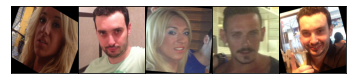

In [6]:

# Show some images.
fig,ax = plt.subplots(1,5, gridspec_kw = {'wspace':0, 'hspace':0}) 
for i in range(0,5,1):
    ax[i].imshow(X[i,:,:])
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

In [14]:
unbiased_data[['age']]

,age
0,4
1,4
2,4
3,4
4,4
...,...
19341,4
19342,4
19343,4
19344,4


In [12]:
np.save('age_image', X[:100])

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=10, 
                    validation_split=0.2)

Epoch 1/10
77/77 [==============================] - 4s 50ms/step - loss: 5.6238 - accuracy: 0.2218 - val_loss: 1.9599 - val_accuracy: 0.2999
Epoch 2/10
77/77 [==============================] - 4s 48ms/step - loss: 1.9999 - accuracy: 0.3035 - val_loss: 1.9226 - val_accuracy: 0.3007
Epoch 3/10
77/77 [==============================] - 4s 52ms/step - loss: 1.9386 - accuracy: 0.2995 - val_loss: 1.8614 - val_accuracy: 0.2991
Epoch 4/10
77/77 [==============================] - 4s 53ms/step - loss: 1.9130 - accuracy: 0.2942 - val_loss: 1.8438 - val_accuracy: 0.3028
Epoch 5/10
77/77 [==============================] - 4s 52ms/step - loss: 1.8795 - accuracy: 0.2986 - val_loss: 1.8379 - val_accuracy: 0.3056
Epoch 6/10
77/77 [==============================] - 4s 53ms/step - loss: 1.8517 - accuracy: 0.3024 - val_loss: 1.7855 - val_accuracy: 0.3142
Epoch 7/10
77/77 [==============================] - 4s 54ms/step - loss: 1.8202 - accuracy: 0.3201 - val_loss: 1.7728 - val_accuracy: 0.3298
Epoch 8/10
77

4/4 - 9s - loss: 7.5057 - accuracy: 0.2600


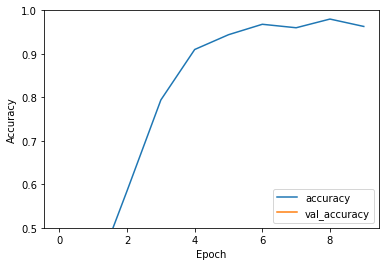

In [235]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test[:100],  y_test[:100], verbose=2)

In [50]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)

    #for layer in base_model.layers:
    #    layer.trainable = False

age_model = base_model.output
age_model = layers.GlobalMaxPooling2D()(age_model)
age_model = layers.Dropout(0.5)(age_model)
age_model = layers.Dense(100, activation="relu")(age_model)
age_model = layers.Dropout(0.5)(age_model)
age_model = layers.Dense(8, activation="softmax")(age_model)

base_model = tf.keras.Model(base_model.input, age_model, name="base_model")

In [51]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = base_model.fit(X_train, y_train, batch_size=128, epochs=10, 
                    validation_split=0.2)

Epoch 1/10
77/77 [==============================] - 819s 11s/step - loss: 4.0147 - accuracy: 0.2613 - val_loss: 2.0564 - val_accuracy: 0.2995
Epoch 2/10
77/77 [==============================] - 824s 11s/step - loss: 1.9191 - accuracy: 0.2944 - val_loss: 1.8795 - val_accuracy: 0.2995
Epoch 3/10
77/77 [==============================] - 824s 11s/step - loss: 1.8004 - accuracy: 0.2990 - val_loss: 1.9784 - val_accuracy: 0.3200
Epoch 4/10
77/77 [==============================] - 817s 11s/step - loss: 1.7440 - accuracy: 0.3614 - val_loss: 1.7442 - val_accuracy: 0.3854
Epoch 5/10
77/77 [==============================] - 816s 11s/step - loss: 1.6387 - accuracy: 0.3981 - val_loss: 2.0435 - val_accuracy: 0.3903
Epoch 6/10
77/77 [==============================] - 813s 11s/step - loss: 1.4907 - accuracy: 0.4410 - val_loss: 36.2406 - val_accuracy: 0.2177
Epoch 7/10
77/77 [==============================] - 819s 11s/step - loss: 1.2839 - accuracy: 0.5016 - val_loss: 1.2945 - val_accuracy: 0.5033
Epoch